# Transfer Learning on STL 10

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
PATH = "./data/"
sz=64
batch_size=32
num_classes=10

#Image Shape
HEIGHT = sz
WIDTH = sz
DEPTH = 3

In [3]:
from __future__ import print_function
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib
import numpy as np
import time
from scipy.io import loadmat

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
from keras.utils import np_utils
from keras import optimizers
from sklearn.model_selection import StratifiedShuffleSplit

Using TensorFlow backend.


In [4]:
!rm -rf data
!mkdir data


### Load the STL10 dataset

In [4]:
# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_matlab.tar.gz'

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [6]:
download_and_extract()

In [5]:
# path to the binary train file with image data
TRAIN_DATA_PATH = './data/stl10_matlab/train.mat'

# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_matlab/test.mat'

# path to the binary test file with image data
UNLABELED_DATA_PATH = './data/stl10_matlab/unlabeledt.mat'

In [6]:
trainset = loadmat(TRAIN_DATA_PATH)
testset = loadmat(TEST_DATA_PATH)


In [7]:
trainset['X']=trainset['X'].reshape(-1,3,96,96).transpose(0,3,2,1)
testset['X']=testset['X'].reshape(-1,3,96,96).transpose(0,3,2,1)
print(trainset['X'].shape)
print(trainset['y'].shape)

(5000, 96, 96, 3)
(5000, 1)


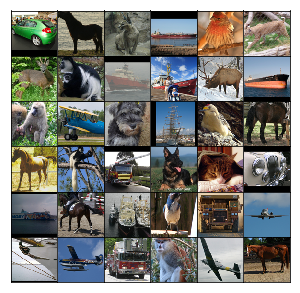

In [8]:
idx = np.random.randint(0, trainset['X'].shape[0], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)


### Create train, validation and test sets  

In [9]:
import cv2
train_data=[]
test_data=[]
print(trainset['X'].shape)
for i in range(0, trainset['X'].shape[0]):
    train_data.append(cv2.resize(trainset['X'][i], (224, 224)))
X_train=np.array(train_data)

for i in range(0, testset['X'].shape[0]):
    test_data.append(cv2.resize(testset['X'][i], (224, 224)))
X_test=np.array(test_data)


y_train=trainset['y'].reshape(-1)-1
y_train = np_utils.to_categorical(y_train, num_classes)

y_test=testset['y'].reshape(-1)-1
y_test = np_utils.to_categorical(y_test, num_classes)

X_val=None
Y_val=None

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, val_index in sss.split(X_train,y_train):
    X_train, X_valid = X_train[train_index], X_train[val_index]
    y_train, y_valid = y_train[train_index], y_train[val_index]   
      

(5000, 96, 96, 3)


(3750, 224, 224, 3)
(3750, 10)
(1250, 224, 224, 3)
(1250, 10)


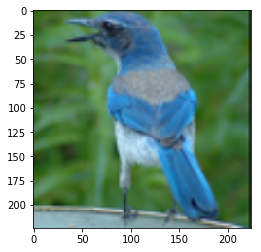

In [10]:
plt.imshow(X_train[0])
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

### Image augmentation using Keras Image Generators

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=40,
    horizontal_flip=True,)

train_datagen.fit(X_train)

mean=train_datagen.mean
std=train_datagen.std

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X_train,y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(X_valid,y_valid,
    shuffle=False,
    batch_size=batch_size)

### Create the model

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

In [13]:
for layer in base_model.layers:
    layer.trainable = False
model = Model(inputs=base_model.input, outputs=predictions)
adam=optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
%%time
history=model.fit_generator(train_generator, train_generator.n // batch_size, epochs=25, verbose=2, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/25
50s - loss: 1.6874 - acc: 0.4247 - val_loss: 0.5262 - val_acc: 0.8842
Epoch 2/25
48s - loss: 0.8629 - acc: 0.7078 - val_loss: 0.3032 - val_acc: 0.9163
Epoch 3/25
48s - loss: 0.6568 - acc: 0.7806 - val_loss: 0.2603 - val_acc: 0.9171
Epoch 4/25
48s - loss: 0.5433 - acc: 0.8118 - val_loss: 0.2221 - val_acc: 0.9278
Epoch 5/25
48s - loss: 0.5116 - acc: 0.8269 - val_loss: 0.2347 - val_acc: 0.9195
Epoch 6/25
48s - loss: 0.4728 - acc: 0.8382 - val_loss: 0.2234 - val_acc: 0.9261
Epoch 7/25
48s - loss: 0.4547 - acc: 0.8497 - val_loss: 0.2059 - val_acc: 0.9294
Epoch 8/25
48s - loss: 0.4099 - acc: 0.8634 - val_loss: 0.1847 - val_acc: 0.9425
Epoch 9/25
48s - loss: 0.3957 - acc: 0.8642 - val_loss: 0.1836 - val_acc: 0.9351
Epoch 10/25
48s - loss: 0.4001 - acc: 0.8629 - val_loss: 0.1959 - val_acc: 0.9319
Epoch 11/25
48s - loss: 0.3579 - acc: 0.8800 - val_loss: 0.1749 - val_acc: 0.9409
Epoch 12/25
48s - loss: 0.3555 - acc: 0.8754 - val_loss: 0.1737 - val_acc: 0.9384
Epoch 13/25
48s - loss: 0

In [18]:
score = model.evaluate(X_test, y_test, batch_size=32)


8000/8000 [==============================] - 84s    


In [19]:
print("Overall accuracy on testset : {}".format(score))

Overall accuracy on testset : [0.57733432167768484, 0.81774999999999998]


### Visualisation

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


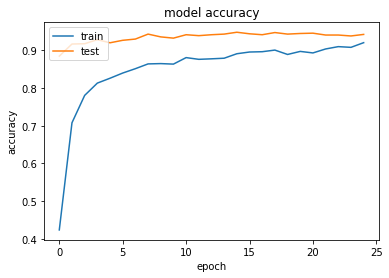

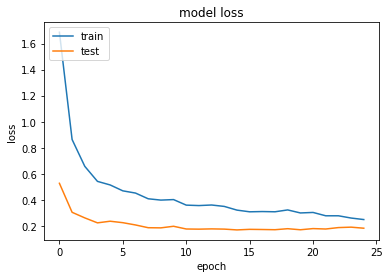

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### References

1. https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#53544c2d3130